In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer


In [20]:
df = pd.read_csv('data/reddit_depression_suicidewatch_encoded.csv')
sentences = df['text'].values
y = df['label_encoded'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.3, random_state=1000)
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)
input_dim = X_train.shape[1]  # Number of features

In [21]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[0, :])

[1023   40   88  177   60  377   61   56   88   46  245  256    7  139
  219    1    8 1062   55    3  910    1    8  101  377   22 1055   63
  254  193  243    1 1240   33   15  185    1   50    6  114   31   21
   71   40    1   59  261   67  330    3    1   34  261  100    6  587
   92   17 4847  392  492  346   16    7  428  296   22  261   16    5
 2129  129   16    7  615  368   16    7  296   15   10  778  706    1
    8  887  184    2   65   15    4  208 1788   39   25   76   40    1
   59  261]


In [30]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          3068800   
                                                                 
 dropout_3 (Dropout)         (None, 100, 100)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 dropout_4 (Dropout)         (None, 96, 128)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

In [31]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4224 - accuracy: 0.8142 - val_loss: 0.5952 - val_accuracy: 0.6785
Epoch 2/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4218 - accuracy: 0.8123 - val_loss: 0.6020 - val_accuracy: 0.6767
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4134 - accuracy: 0.8191 - val_loss: 0.6081 - val_accuracy: 0.6746
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4053 - accuracy: 0.8255 - val_loss: 0.6168 - val_accuracy: 0.6746
Epoch 5/10
223/223 [==============================] - 1s 6ms/step - loss: 0.3930 - accuracy: 0.8257 - val_loss: 0.6188 - val_accuracy: 0.6672
Epoch 6/10
223/223 [==============================] - 1s 6ms/step - loss: 0.3888 - accuracy: 0.8264 - val_loss: 0.6290 - val_accuracy: 0.6706
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.3850 - accuracy: 0.8342 - val_loss: 0.6343 - val_accuracy: 0.6747
Epoch 

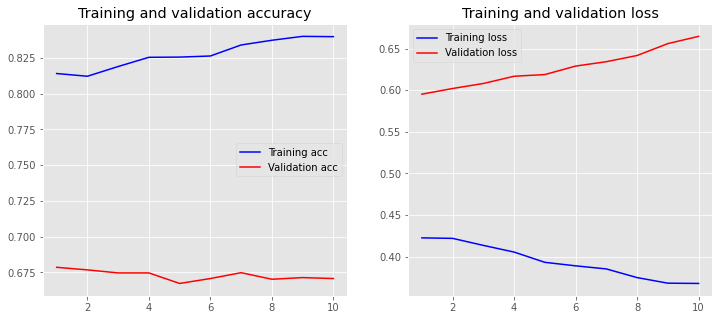

In [34]:
from keras.backend import clear_session
clear_session()
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [35]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [37]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000],
                  embedding_dim=[50],
                  maxlen=[100])

In [39]:
df['source'] = 'reddit'
df.head()

,label_encoded,text,source
0,0,I recently went through a breakup and she said...,reddit
1,0,"I do not know how to navigate these feelings, ...",reddit
2,0,"So I have been with my bf for 5 months , and h...",reddit
3,1,I am so exhausted of this. Just when I think I...,reddit
4,0,I have been severly bullied since i was 5 till...,reddit


In [41]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['text'].values
    y = df['label_encoded'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : reddit


C:\Users\sathy\AppData\Local\Temp\ipykernel_26496\2638934989.py:39: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


Fitting 4 folds for each of 5 candidates, totalling 20 fits
Running reddit data set
Best Accuracy : 0.6657
{'vocab_size': 31686, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.6527


